# Assignment 3 Modulation Recognition
---

### 1) Download data
---

In [1]:
#Mount the google drive to manage files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd gdrive/My\ Drive/Colab\ Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [0]:
#Downloading the dataset for the first time to the drive
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

--2019-04-30 15:25:44--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  13.4MB/s    in 81s     

2019-04-30 15:27:05 (14.7 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
#Extracting the file for the first time
!tar xjf "RML2016.10b.tar.bz2"

In [3]:
import numpy as np
import pickle
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Dropout
from sklearn import preprocessing
from scipy.integrate import cumtrapz
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
import pandas as pd
from string import atoi
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
# Load the dataset
# Xd = pickle.load(open("RML2016.10b.dat",'rb'))

# snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
# X = []  
# lbl = []
# for mod in mods:
#     for snr in snrs:
#          X.append(Xd[(mod,snr)])
#          for i in range(Xd[(mod,snr)].shape[0]):  
#           lbl.append(np.array([mod,snr]))
# X = np.vstack(X)

# labels = np.asarray(lbl)
# #Save the labels to easily manage the memory
# np.save('labels' , labels)


## 2) Create feature spaces
--

In [0]:
#Additional feature spaces

#Evaluating the differentiation and integration of the signals then saving the arrays

#X_diff=np.apply_along_axis(np.gradient, 1, data)
#X_integ=np.apply_along_axis(cumtrapz, 1, data, initial=0)
#np.save('X_diff',X_diff)
#np.save('X_integ',X_integ)
#X_diff=np.load('X_diff.npy')
#X_integ=np.load('X_integ.npy')


In [0]:
#Combining all the features together

# newDataset = []

# for i in range(0,data.shape[0]):
#   newDataset.append(np.vstack((X[i], X_diff[i] , X_integ[i])))
  
# newDataset = np.array(newDataset)


##3) Supervised learning step

In [0]:
#Load the saved files
X_rawdiffinteg = np.load('X_rawdiffinteg.npy')
labels = pd.DataFrame(np.load('labels.npy') , columns=['mod', 'snr'])

In [0]:
#Binarize the modulation types for the models
lb = preprocessing.LabelBinarizer()
binarized_labels = lb.fit_transform(labels['mod'])

temp = []
for row in binarized_labels:
  temp.append(tuple(row))
  

labels['mod'] = temp


In [6]:
#Splitting the dataset 50 50
training_set,test_set,training_set_labels,test_set_labels = train_test_split(X_rawdiffinteg, labels, test_size=0.5,shuffle=True ,random_state=42)

# training_set = X_rawdiffinteg[1::2]
# test_set = X_rawdiffinteg[0::2]
# training_set_labels = labels.iloc[1::2]
# test_set_labels = labels.iloc[0::2]

#Adjusting the labels for the confusion matrix and splitting the test set according to the snr

print training_set.shape , test_set.shape
print training_set_labels.shape , test_set_labels.shape

class SnrTestGroup:
  def __init__(self, test_set, test_set_labels):
    self.test_set = test_set
    self.test_set_labels =test_set_labels

label_groups = test_set_labels.groupby('snr')
label_groups_indices = label_groups.groups


test_sets_dict = {}

for name,group in label_groups:
  test_sets_dict[name] = SnrTestGroup( X_rawdiffinteg[label_groups_indices[name].tolist()] , group)
  

# for value , snr in zip(test_sets_dict.values() , test_sets_dict.keys()):
#   print snr
#   print value.test_set
#   print value.test_set_labels



training_set_labels = np.asarray(training_set_labels['mod'].tolist())




(600000, 6, 128) (600000, 6, 128)
(600000, 2) (600000, 2)


In [19]:
import gc
#Freeing some memory

#del X_rawdiffinteg
#del labels
gc.collect()


81797

In [0]:
num_epochs = 150
batch_size = 1024

In [0]:
def plot_confusion_matrix(cm, title, cmap=plt.cm.Blues):
  labels = ['8PSK','AM-DSB','BPSK','CPFSK','GFSK','PAM4','QAM16','QAM64','QPSK','WBFM']
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
    
def adjust(x):
  results = []
  for row in x:
    results.append(np.argmax(row))
  return results 
    

def display_plot(test_labels,predicted_labels,name):
  confusion = confusion_matrix(adjust(test_labels),adjust(predicted_labels))
  normal_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
  plt.figure()
  plot_confusion_matrix(normal_confusion,"Confusion matrix for SNR " + name)
  
  
def plot_accuracy(acc,snr):
  plt.figure()
  plt.plot(snr, acc)
  plt.xlabel("Signal to Noise Ratio")
  plt.ylabel("Classification Accuracy")
  plt.title("Classification Accuracy on RadioML 2016.10 Beta")
  print "The average overall accuracy is " + str(np.sum(acc)/float(np.ma.count(acc)))

  
  
  

In [0]:
def fully_conn_model(training_set , test_set , training_labels , test_labels,name):
  # Create a fully connected model
  model = Sequential()

  model.add(Reshape((training_set.shape[1]*training_set.shape[2],),input_shape=(training_set.shape[1],training_set.shape[2])))
  model.add(Dense(512, init='uniform', activation='relu'))
  model.add(Dense(256, init='uniform', activation='relu'))
  model.add(Dense(10, init='uniform', activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Display layers
  model.summary()

  # Fit the model
  model.fit(training_set, training_set_labels, epochs=10, batch_size=1024, validation_split=0.05, verbose = 2,
            callbacks=[EarlyStopping(monitor='val_loss',patience=10,verbose=1, mode='min')])

  # Evaluate performance
  score = model.evaluate(test_set, test_labels, verbose=1, batch_size=batch_size)
  print 'score is ' , score[0] , 'classification accuracy is ' , score[1]*100
  
  #plot
  predicted_labels = model.predict(test_set,batch_size)
  display_plot(test_labels,predicted_labels,name)
  
  return score[1]

In [0]:
def cnn_model(training_set , test_set , training_labels , test_labels, name):
  
  # Create a CNN model
  
  model = Sequential()
  model.add(Reshape((training_set.shape[2],training_set.shape[1],1),input_shape=(training_set.shape[1],training_set.shape[2])))
  model.add(Conv2D(filters = 64,kernel_size=(1,3),padding="same", data_format='channels_last', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Conv2D(filters = 16,kernel_size=(2,3),padding="same",data_format='channels_last', activation='relu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(128, init='uniform', activation='relu'))
  model.add(Dense(10, init='uniform', activation='softmax'))

  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Display layers
  model.summary()

  # Fit the model
  model.fit(training_set, training_set_labels, epochs=10, batch_size=1024, validation_split=0.05, verbose = 2,
            callbacks=[EarlyStopping(monitor='val_loss',patience=10,verbose=1, mode='min')])

 
  # Evaluate performance
  score = model.evaluate(test_set, test_labels, verbose=1, batch_size=batch_size)
  print 'score is ' , score[0] , 'classification accuracy is ' , score[1]*100
  
  #plot
  predicted_labels = model.predict(test_set,batch_size)
  display_plot(test_labels,predicted_labels,name)

  return score[1]
  

##4) Big picture

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="uniform")`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", kernel_initializer="uniform")`
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="uniform")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_67 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_68 (Dense)             (None, 10)                2570      
Total params: 265,482
Trainable params: 265,482
Non-trainable params: 0
_________________________________________________________________
Train on 570000 samples, validate on 30000 samples
Epoch 1/10
 - 8s - loss: 1.9709 - acc: 0.2191 - val_loss: 1.7987 - val_acc: 0.2906
Epoch 2/10
 - 5s - loss: 1.7492 - acc: 0.3043 - val_loss: 1.7235 - val_acc: 0.3128
Epoch 3/10
 - 5s - loss: 1.6968 - acc: 0.3294 - val

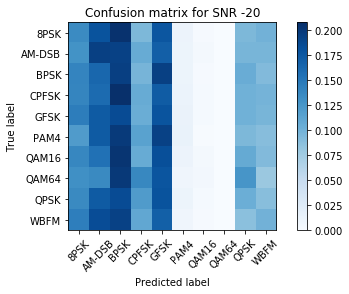

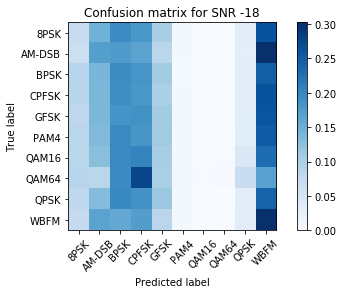

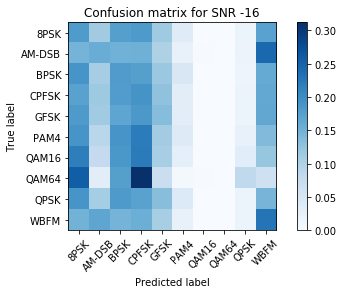

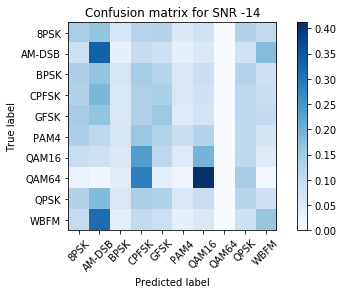

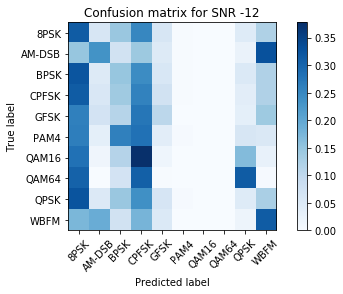

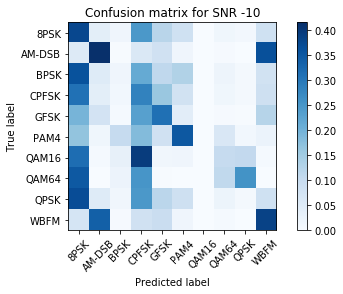

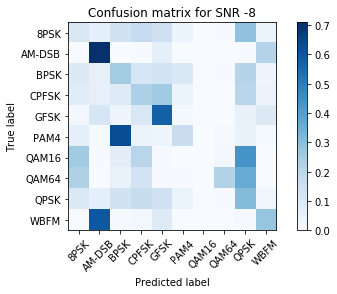

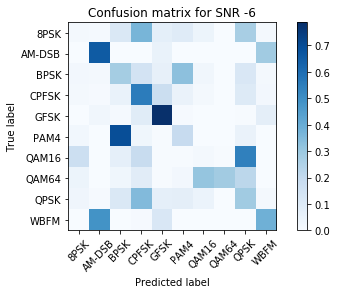

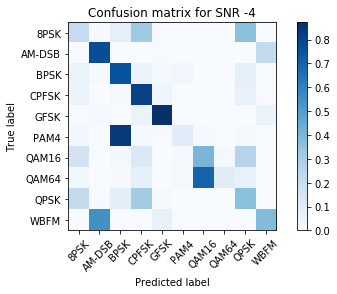

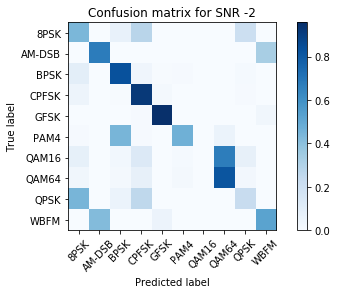

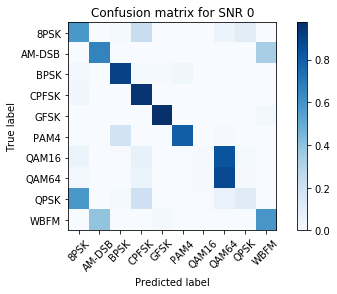

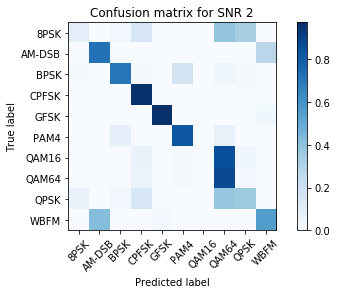

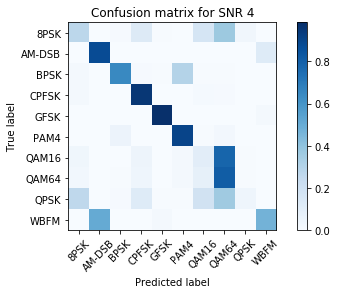

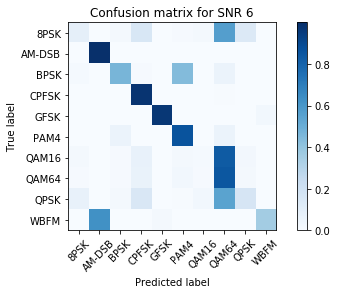

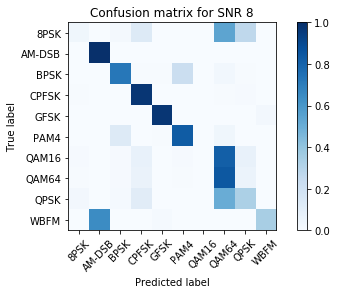

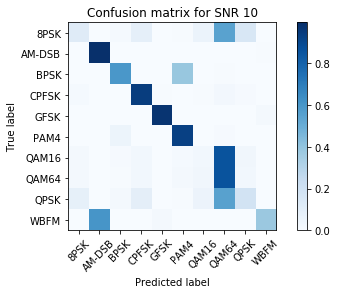

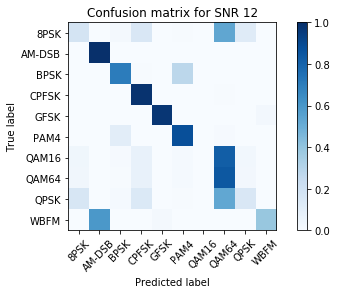

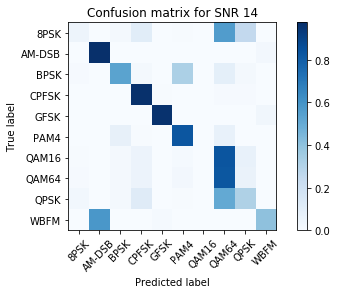

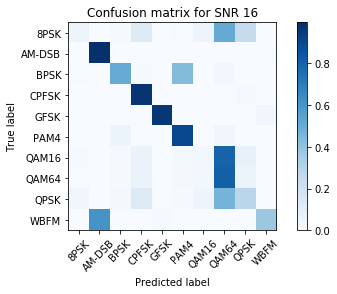

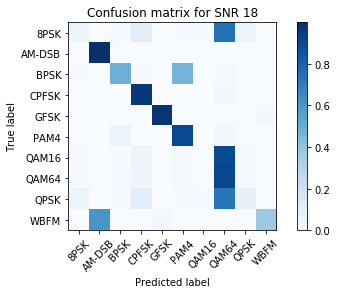

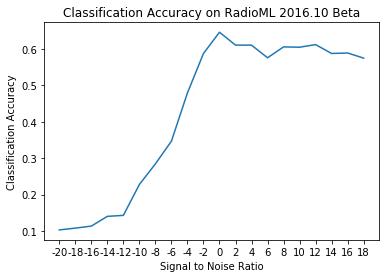

In [17]:
#Running all the models

# Raw features only (fully connected)

accs = []

snrs = []

list1 = [int(x) for x in test_sets_dict.keys()]

list1.sort()

list2 = [str(x) for x in list1]

for snr in list2:
  snr_test_set = test_sets_dict[snr].test_set[:,0:2]
  snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
  accu=fully_conn_model(training_set[:,0:2],snr_test_set,training_set_labels,snr_test_set_labels,snr)
  accs.append(accu)
  snrs.append(snr)

plot_accuracy(accs,snrs)



# diff features only  (fully connected)

# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set[:,2:4]
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=fully_conn_model(training_set[:,2:4],test_set[:,2:4],training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)



# integration features only  (fully connected)
# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set[:,4:6]
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=fully_conn_model(training_set[:,4:6],test_set[:,4:6],training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)



# raw + diff + integ (fully connected)

# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=fully_conn_model(training_set,test_set,training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)




/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="uniform")`
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="uniform")`
  del sys.path[0]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_43 (Reshape)         (None, 128, 2, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 2, 64)        256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 2, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 2, 16)        6160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 2, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 128)               524416    
__________

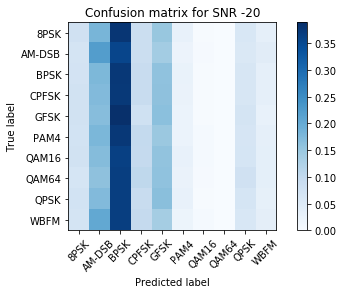

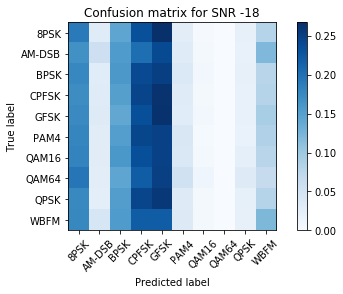

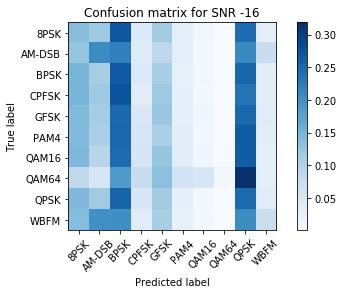

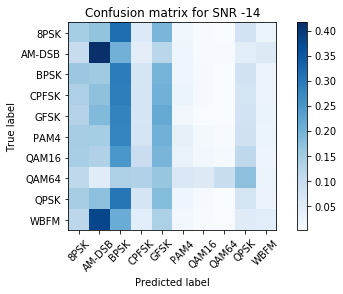

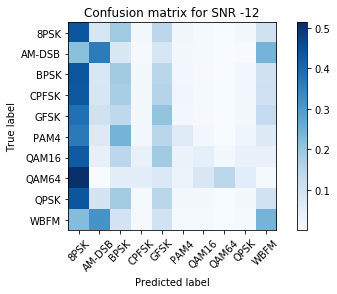

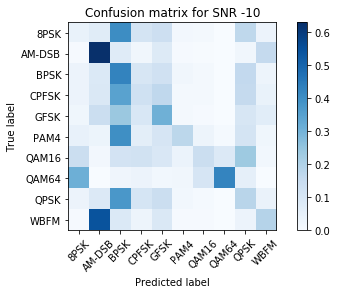

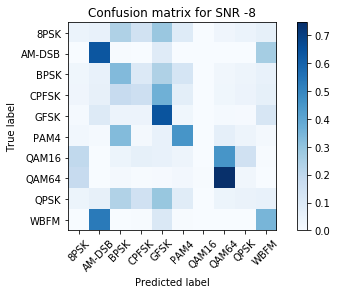

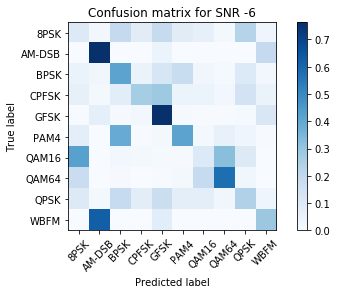

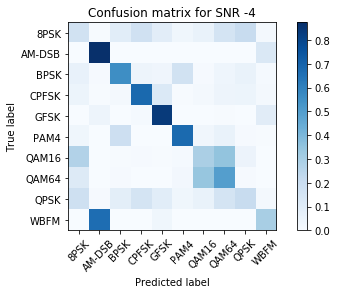

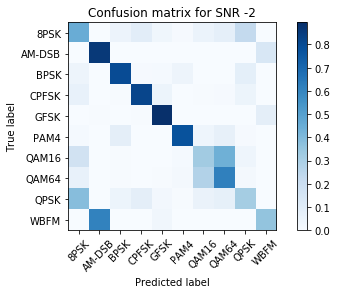

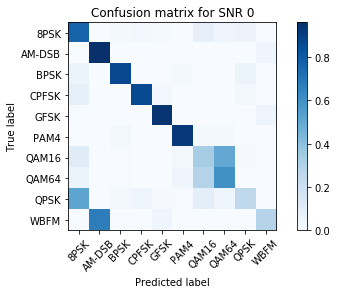

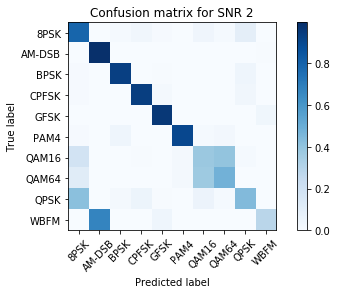

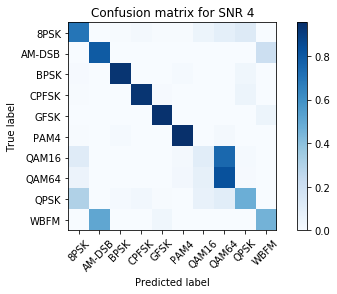

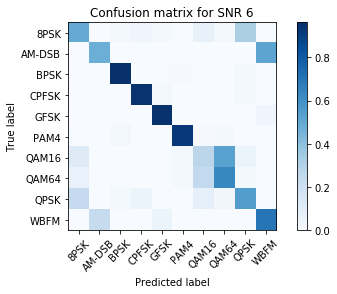

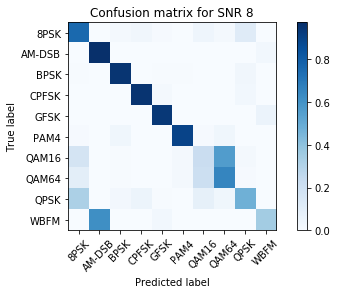

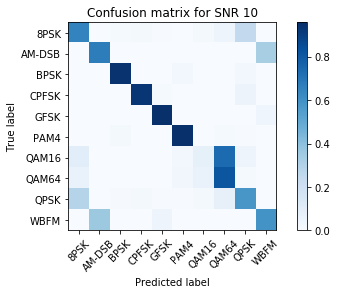

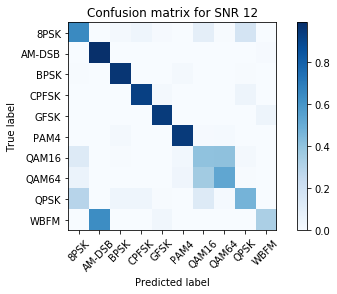

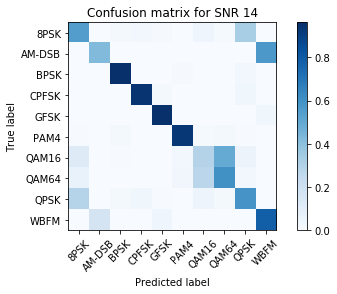

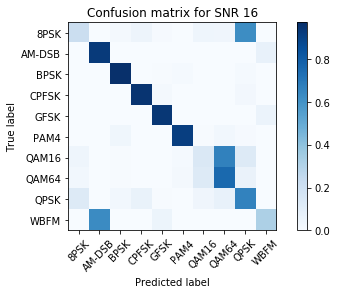

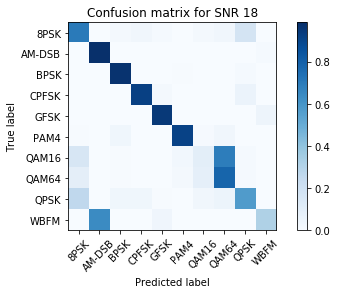

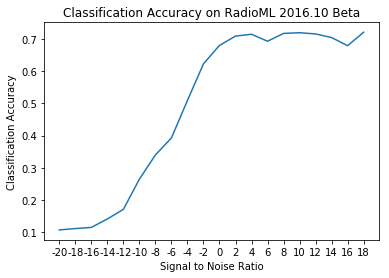

In [18]:
# Raw features only (cnn)
 
accs = []

snrs = []

list1 = [int(x) for x in test_sets_dict.keys()]

list1.sort()

list2 = [str(x) for x in list1]

for snr in list2:
  snr_test_set = test_sets_dict[snr].test_set[:,0:2]
  snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
  accu=cnn_model(training_set[:,0:2],snr_test_set,training_set_labels,snr_test_set_labels,snr)
  accs.append(accu)
  snrs.append(snr)

plot_accuracy(accs,snrs)




# diff features only  (fully connected)

# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set[:,2:4]
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=cnn_model(training_set[:,2:4],test_set[:,2:4],training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)



# integration features only  (fully connected)
# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set[:,4:6]
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=cnn_model(training_set[:,4:6],test_set[:,4:6],training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)



# raw + diff + integ (fully connected)

# accs = []

# snrs = []

# list1 = [int(x) for x in test_sets_dict.keys()]

# list1.sort()

# list2 = [str(x) for x in list1]

# print list2

# for snr in list2:
#   snr_test_set = test_sets_dict[snr].test_set
#   snr_test_set_labels = np.asarray(test_sets_dict[snr].test_set_labels['mod'].tolist())
#   accu=cnn_model(training_set,test_set,training_set_labels,test_set_labels,snr)
#   accs.append(accu)
#   snrs.append(snr)

# plot_accuracy(accs,snrs)



